In [2]:
import numpy as np
import cupy as cp
import sunpy.map,sunpy
import time
import matplotlib.pyplot as plt
from astropy.stats import gaussian_fwhm_to_sigma

from data_utils.calculating_DN import calculate_DN_alpha, calculate_DN_beta
from data_utils.calculating_DN import angle_point_num_alpha, angle_point_num_beta, wavelength_point_num
from data_utils.calculating_DN import calculating_DN_4096

from data_utils.data.aia_const import wavelength_list_aia_relative_Single_A

In [3]:
aia_file = 'data_utils\\data\\AIA\\aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1_adjusted.fits'
smap = sunpy.map.Map(aia_file)
image=smap.data

In [4]:
%%timeit -r 5 -n 5
# np-> cp transform every time
irradiance=calculating_DN_4096(image,wavelength_list_aia_relative_Single_A,0,0,dtype=cp.float32)

308 ms ± 29.9 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


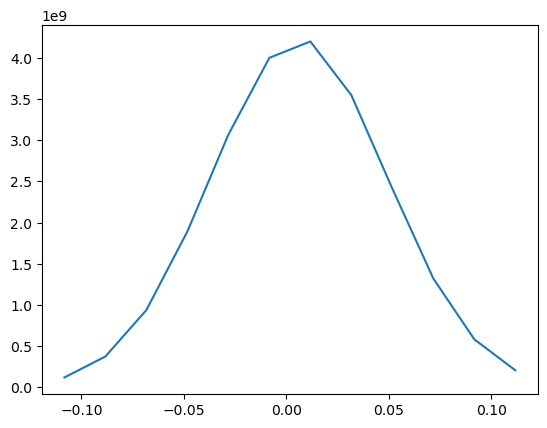

In [5]:
irradiance=calculating_DN_4096(image,wavelength_list_aia_relative_Single_A,0,0,dtype=cp.float32)
plt.plot(wavelength_list_aia_relative_Single_A,irradiance)

In [21]:
%%timeit -r 5 -n 5    image_cp=cp.asarray(image)
# np-> cp transform ahead of time
irradiance=calculating_DN_4096(image_cp,wavelength_list_aia_relative_Single_A,0,0,dtype=cp.float32)

304 ms ± 21.8 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


## Detail time consumption
I copy the whole calculating_DN function line by line into each cell.
Note:
1. %% timeit      has a independent Variable scope
       实参可以是cell 之外的定义的。。。但是其他时候这个变量不能做其他事情，比如在赋值等式中
       
2.  If I copy the func into cell and execute it,    it takes  60ms
    But if call the same func from a py file,       it takes 380ms

In [ ]:
import numpy as np
import cupy as cp
import sunpy.map,sunpy
import time
import matplotlib.pyplot as plt
from astropy.stats import gaussian_fwhm_to_sigma

# from data_utils.calculating_DN import calculate_DN_alpha, calculate_DN_beta
# from data_utils.calculating_DN import angle_point_num_alpha, angle_point_num_beta, wavelength_point_num
# from data_utils.calculating_DN import calculating_DN_4096
# from data_utils.calculating_DN_np import calculating_DN_4096_np

from data_utils.data.aia_const import wavelength_list_aia_relative_Single_A

In [3]:
# read pixel to world matrix: Tx and Ty
coeff = np.load('data_utils//pixel_to_world//coeff_4096.npz')
Tx_4096=cp.array(coeff['Tx'])
Ty_4096=cp.array(coeff['Ty'])

In [4]:
aia_file = 'data_utils\\data\\AIA\\aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1_adjusted.fits'
smap = sunpy.map.Map(aia_file)
image=smap.data

In [5]:
def wavelength_shift(Tx, Ty, A=886.81, B=0.91002):
    return A * Tx**2 + B * Ty


def my_Gaussian1D(wavelength_list, amplitude, mean, stddev):
    # Check if the input arrays have the same shape
    # assert amplitude.shape == mean.shape == stddev.shape == (4096, 4096), "Input arrays must have shape (2048, 2048)"

    # Expand the dimensions of wavelength_list to match the shape of amplitude, mean, and stddev
    expanded_wavelengths = cp.expand_dims(wavelength_list, axis=(1, 2))

    # Calculate the Gaussian curve for all wavelengths simultaneously using Cupy element-wise operations
    results = amplitude * cp.exp(-((expanded_wavelengths - mean) ** 2) / (2 * stddev ** 2))

    return results



def calculating_DN_4096(image,wavelength_list, offaxis_angle_x, offaxis_angle_y,dtype=cp.float32):
    [image_shape_x, image_shape_y]=image.shape
    # ensure that the image is 4096*4096, if not raise error
    if image_shape_x != 4096 or image_shape_y != 4096:
        raise ValueError("The shape of image is not 4096*4096")
    # turn array into cupy array
    wavelength_list=cp.asarray(wavelength_list)

    if isinstance(image, np.ndarray):
        image=cp.asarray(image,dtype=dtype)   
    

    # This assupmtion is actually nonsense, and will be solved in Chpater 4
    stddev = cp.full((image_shape_x, image_shape_y),0.1 *gaussian_fwhm_to_sigma ) # unit: nm

    # Create NumPy arrays for pixel indices and image data
    Tx = Tx_4096+offaxis_angle_x  # P42 步骤三 四 将卫星整体偏转
    Ty = Ty_4096+offaxis_angle_y  # P42 步骤三 四 将卫星整体偏转

    
    # Compute amplitude, mean, and stddev for all pixels in parallel
    amplitude = image / (cp.sqrt(2 * cp.pi) * stddev)
    mean = wavelength_shift(Tx, Ty)
    coeff = cp.array([amplitude, mean, stddev])
    # Compute total_irradiance using vectorized NumPy operations
    total_irradiance = cp.sum(my_Gaussian1D(
        wavelength_list, *coeff), axis=(1, 2))  # P42 步骤二

    return total_irradiance.get()  # turn cupy array into numpy array

### silly timeit

In [7]:
%%timeit -r 50 -n 1000
# aia_file = 'data_utils\\data\\AIA\\aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1_adjusted.fits'
# smap = sunpy.map.Map(aia_file)
image=smap.data

55.3 ns ± 9.29 ns per loop (mean ± std. dev. of 50 runs, 1,000 loops each)


In [27]:
%%timeit -r 50 -n 100
wavelength_list=wavelength_list_aia_relative_Single_A
offaxis_angle_x=0
offaxis_angle_y=0
dtype=cp.float32
image=smap.data



216 ns ± 13.9 ns per loop (mean ± std. dev. of 50 runs, 100 loops each)


In [9]:
%%timeit -r 50 -n 500
wavelength_list=wavelength_list_aia_relative_Single_A
offaxis_angle_x=0
offaxis_angle_y=0
dtype=cp.float32
image=smap.data


[image_shape_x, image_shape_y]=image.shape
# ensure that the image is 4096*4096, if not raise error
if image_shape_x != 4096 or image_shape_y != 4096:
    raise ValueError("The shape of image is not 4096*4096")
    
# turn array into cupy array
wavelength_list=cp.asarray(wavelength_list)

The slowest run took 4.44 times longer than the fastest. This could mean that an intermediate result is being cached.
19.7 µs ± 7.58 µs per loop (mean ± std. dev. of 50 runs, 500 loops each)


In [28]:
%%timeit -r 5 -n 10
wavelength_list=wavelength_list_aia_relative_Single_A
offaxis_angle_x=0
offaxis_angle_y=0
dtype=cp.float32
image=smap.data

[image_shape_x, image_shape_y]=image.shape

# 50 ms
if isinstance(image, np.ndarray):
    image=cp.asarray(image,dtype=dtype) 
    
stddev = cp.full((image_shape_x, image_shape_y),0.1 *gaussian_fwhm_to_sigma ) # unit: nm

46.9 ms ± 3.37 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [12]:
%%timeit -r 5 -n 10
wavelength_list=wavelength_list_aia_relative_Single_A
offaxis_angle_x=0
offaxis_angle_y=0
dtype=cp.float32
image=smap.data


# Create NumPy arrays for pixel indices and image data
Tx = Tx_4096+offaxis_angle_x  # P42 步骤三 四 将卫星整体偏转
Ty = Ty_4096+offaxis_angle_y  # P42 步骤三 四 将卫星整体偏转

86.9 µs ± 23.4 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [31]:
%%timeit -r 5 -n 10

wavelength_list=wavelength_list_aia_relative_Single_A
offaxis_angle_x=0
offaxis_angle_y=0
dtype=cp.float32
image=smap.data
Tx = Tx_4096+offaxis_angle_x  # P42 步骤三 四 将卫星整体偏转
Ty = Ty_4096+offaxis_angle_y  # P42 步骤三 四 将卫星整体偏转
[image_shape_x, image_shape_y]=image.shape

if isinstance(image, np.ndarray):
    image=cp.asarray(image,dtype=dtype) 

    

mean = wavelength_shift(Tx, Ty)
stddev = cp.full((image_shape_x, image_shape_y),0.1 *gaussian_fwhm_to_sigma ) # unit: nm
amplitude = image / (cp.sqrt(2 * cp.pi) * stddev)
coeff = cp.array([amplitude, mean, stddev])

57.5 ms ± 4.79 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [34]:
def my_Gaussian1D(wavelength_list, amplitude, mean, stddev):
    # Check if the input arrays have the same shape
    # assert amplitude.shape == mean.shape == stddev.shape == (4096, 4096), "Input arrays must have shape (2048, 2048)"

    # Expand the dimensions of wavelength_list to match the shape of amplitude, mean, and stddev
    expanded_wavelengths = cp.expand_dims(wavelength_list, axis=(1, 2))

    # Calculate the Gaussian curve for all wavelengths simultaneously using Cupy element-wise operations
    results = amplitude * cp.exp(-((expanded_wavelengths - mean) ** 2) / (2 * stddev ** 2))

    return results

In [37]:
coeff

NpzFile 'data_utils//pixel_to_world//coeff_4096.npz' with keys: Tx, Ty

In [56]:
%%timeit -r 2 -n 2

wavelength_list=wavelength_list_aia_relative_Single_A
offaxis_angle_x=0
offaxis_angle_y=0
dtype=cp.float32
image=smap.data
Tx = Tx_4096+offaxis_angle_x  # P42 步骤三 四 将卫星整体偏转
Ty = Ty_4096+offaxis_angle_y  # P42 步骤三 四 将卫星整体偏转
[image_shape_x, image_shape_y]=image.shape
wavelength_list=cp.asarray(wavelength_list)

if isinstance(image, np.ndarray):
    image=cp.asarray(image,dtype=dtype) 

    

mean = wavelength_shift(Tx, Ty)
stddev = cp.full((image_shape_x, image_shape_y),0.1 *gaussian_fwhm_to_sigma ) # unit: nm
amplitude = image / (cp.sqrt(2 * cp.pi) * stddev)
coeff = cp.array([amplitude, mean, stddev])


my_Gaussian1D(wavelength_list, *coeff)

total_irradiance = cp.sum(my_Gaussian1D(
        wavelength_list, *coeff), axis=(1, 2))

62 ms ± 76.2 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [285]:
wavelength_list

array([-0.1083, -0.0883, -0.0683, -0.0483, -0.0283, -0.0083,  0.0117,
        0.0317,  0.0517,  0.0717,  0.0917,  0.1117])

In [317]:
%%timeit -r 5 -n 10
wavelength_list=wavelength_list_aia_relative_Single_A
offaxis_angle_x=0
offaxis_angle_y=0
dtype=cp.float32
image=smap.data
wavelength_list=cp.asarray(wavelength_list)


total_irradiance = cp.sum(my_Gaussian1D(
    wavelength_list, *coeff), axis=(1, 2))  # P42 步骤二

262 ms ± 836 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [309]:
coeff = cp.array([amplitude, mean, stddev])

my_Gaussian1D(wavelength_list, *coeff)

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.01732719e-03, 7.50028929e-03, 1.04603205e-02, ...,
         7.91425051e-03, 5.61388775e-03, 5.60807243e-03],
        [0.00000000e+00, 6.69347309e-04, 0.00000000e+00, ...,
         7.06155302e-03, 1.03252979e-02, 9.03539900e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.27571778e-03, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

## Time consumption: numpy -> cupy  

In [10]:
%%timeit -r 30 -n 50     image_cp=cp.asarray(image)
image_cp=cp.exp(-image_cp)


The slowest run took 202.66 times longer than the fastest. This could mean that an intermediate result is being cached.
1.85 ms ± 1.35 ms per loop (mean ± std. dev. of 30 runs, 50 loops each)


In [11]:
%%timeit -r 10 -n 10 
image_cp=np.asarray(image,
    dtype=np.float64
    )


37 ms ± 1.36 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [18]:
%%timeit -r 10 -n 10 
image_cp=cp.asarray(image,
# dtype='>f4'#cp.float64
dtype=cp.float64
)

45.8 ms ± 872 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [13]:
%%timeit -r 10 -n 10 
image_cp=cp.asarray(image,dtype=cp.float32)

45.3 ms ± 5.26 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [14]:
%%timeit -r 10 -n 10 
image_cp=cp.asarray(image)

47.7 ms ± 2.52 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [27]:
%%timeit -r 10 -n 2 
f()

259 ms ± 2.88 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)


In [26]:
%%timeit -r 10 -n 2 
image**3+9

264 ms ± 6.02 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)


In [21]:
def f():
    return image**3+9